# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2',
    'xgboost': '1.5.0',
}
check_packages(d)

[OK] Your Python version is 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]
[OK] numpy 1.22.1
[OK] scipy 1.7.3
[OK] matplotlib 3.5.1
[OK] sklearn 1.0.2
[OK] pandas 1.4.0
[OK] xgboost 1.5.1


/Users/sebastian/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Chapter 7 - Combining Different Models for Ensemble Learning

<br>
<br>

### Overview

- [Learning with ensembles](#Learning-with-ensembles)
- [Combining classifiers via majority vote](#Combining-classifiers-via-majority-vote)
    - [Implementing a simple majority vote classifier](#Implementing-a-simple-majority-vote-classifier)
    - [Using the majority voting principle to make predictions](#Using-the-majority-voting-principle-to-make-predictions)
    - [Evaluating and tuning the ensemble classifier](#Evaluating-and-tuning-the-ensemble-classifier)
- [Bagging – building an ensemble of classifiers from bootstrap samples](#Bagging----Building-an-ensemble-of-classifiers-from-bootstrap-samples)
    - [Bagging in a nutshell](#Bagging-in-a-nutshell)
    - [Applying bagging to classify examples in the Wine dataset](#Applying-bagging-to-classify-examples-in-the-Wine-dataset)
- [Leveraging weak learners via adaptive boosting](#Leveraging-weak-learners-via-adaptive-boosting)
    - [How boosting works](#How-boosting-works)
    - [Applying AdaBoost using scikit-learn](#Applying-AdaBoost-using-scikit-learn)
- [Gradient boosting -- training an ensemble based on loss gradients](#Gradient-boosting----training-an-ensemble-based-on-loss-gradients)
  - [Comparing AdaBoost with gradient boosting](#Comparing-AdaBoost-with-gradient-boosting)
  - [Outlining the general gradient boosting algorithm](#Outlining-the-general-gradient-boosting-algorithm)
  - [Explaining the gradient boosting algorithm for classification](#Explaining-the-gradient-boosting-algorithm-for-classification)
  - [Illustrating gradient boosting for classification](#Illustrating-gradient-boosting-for-classification)
  - [Using XGBoost](#Using-XGBoost)
- [Summary](#Summary)

<br>
<br>

In [3]:
from IPython.display import Image
%matplotlib inline

# Learning with ensembles

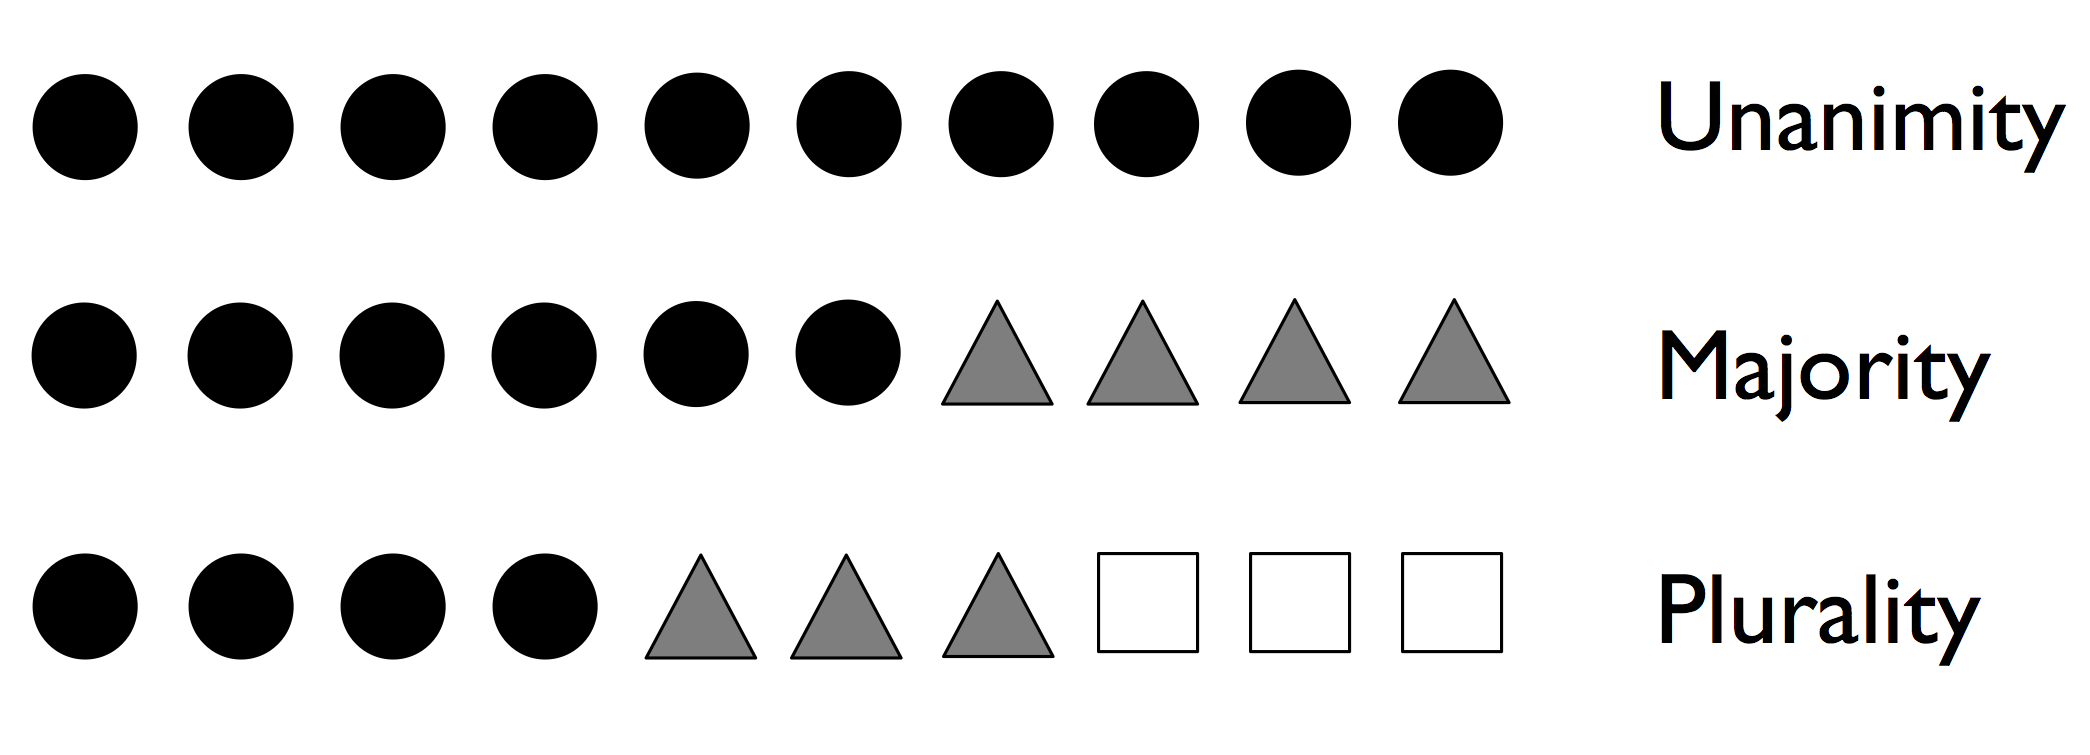

In [4]:
Image(filename='figures/07_01.png', width=500) 

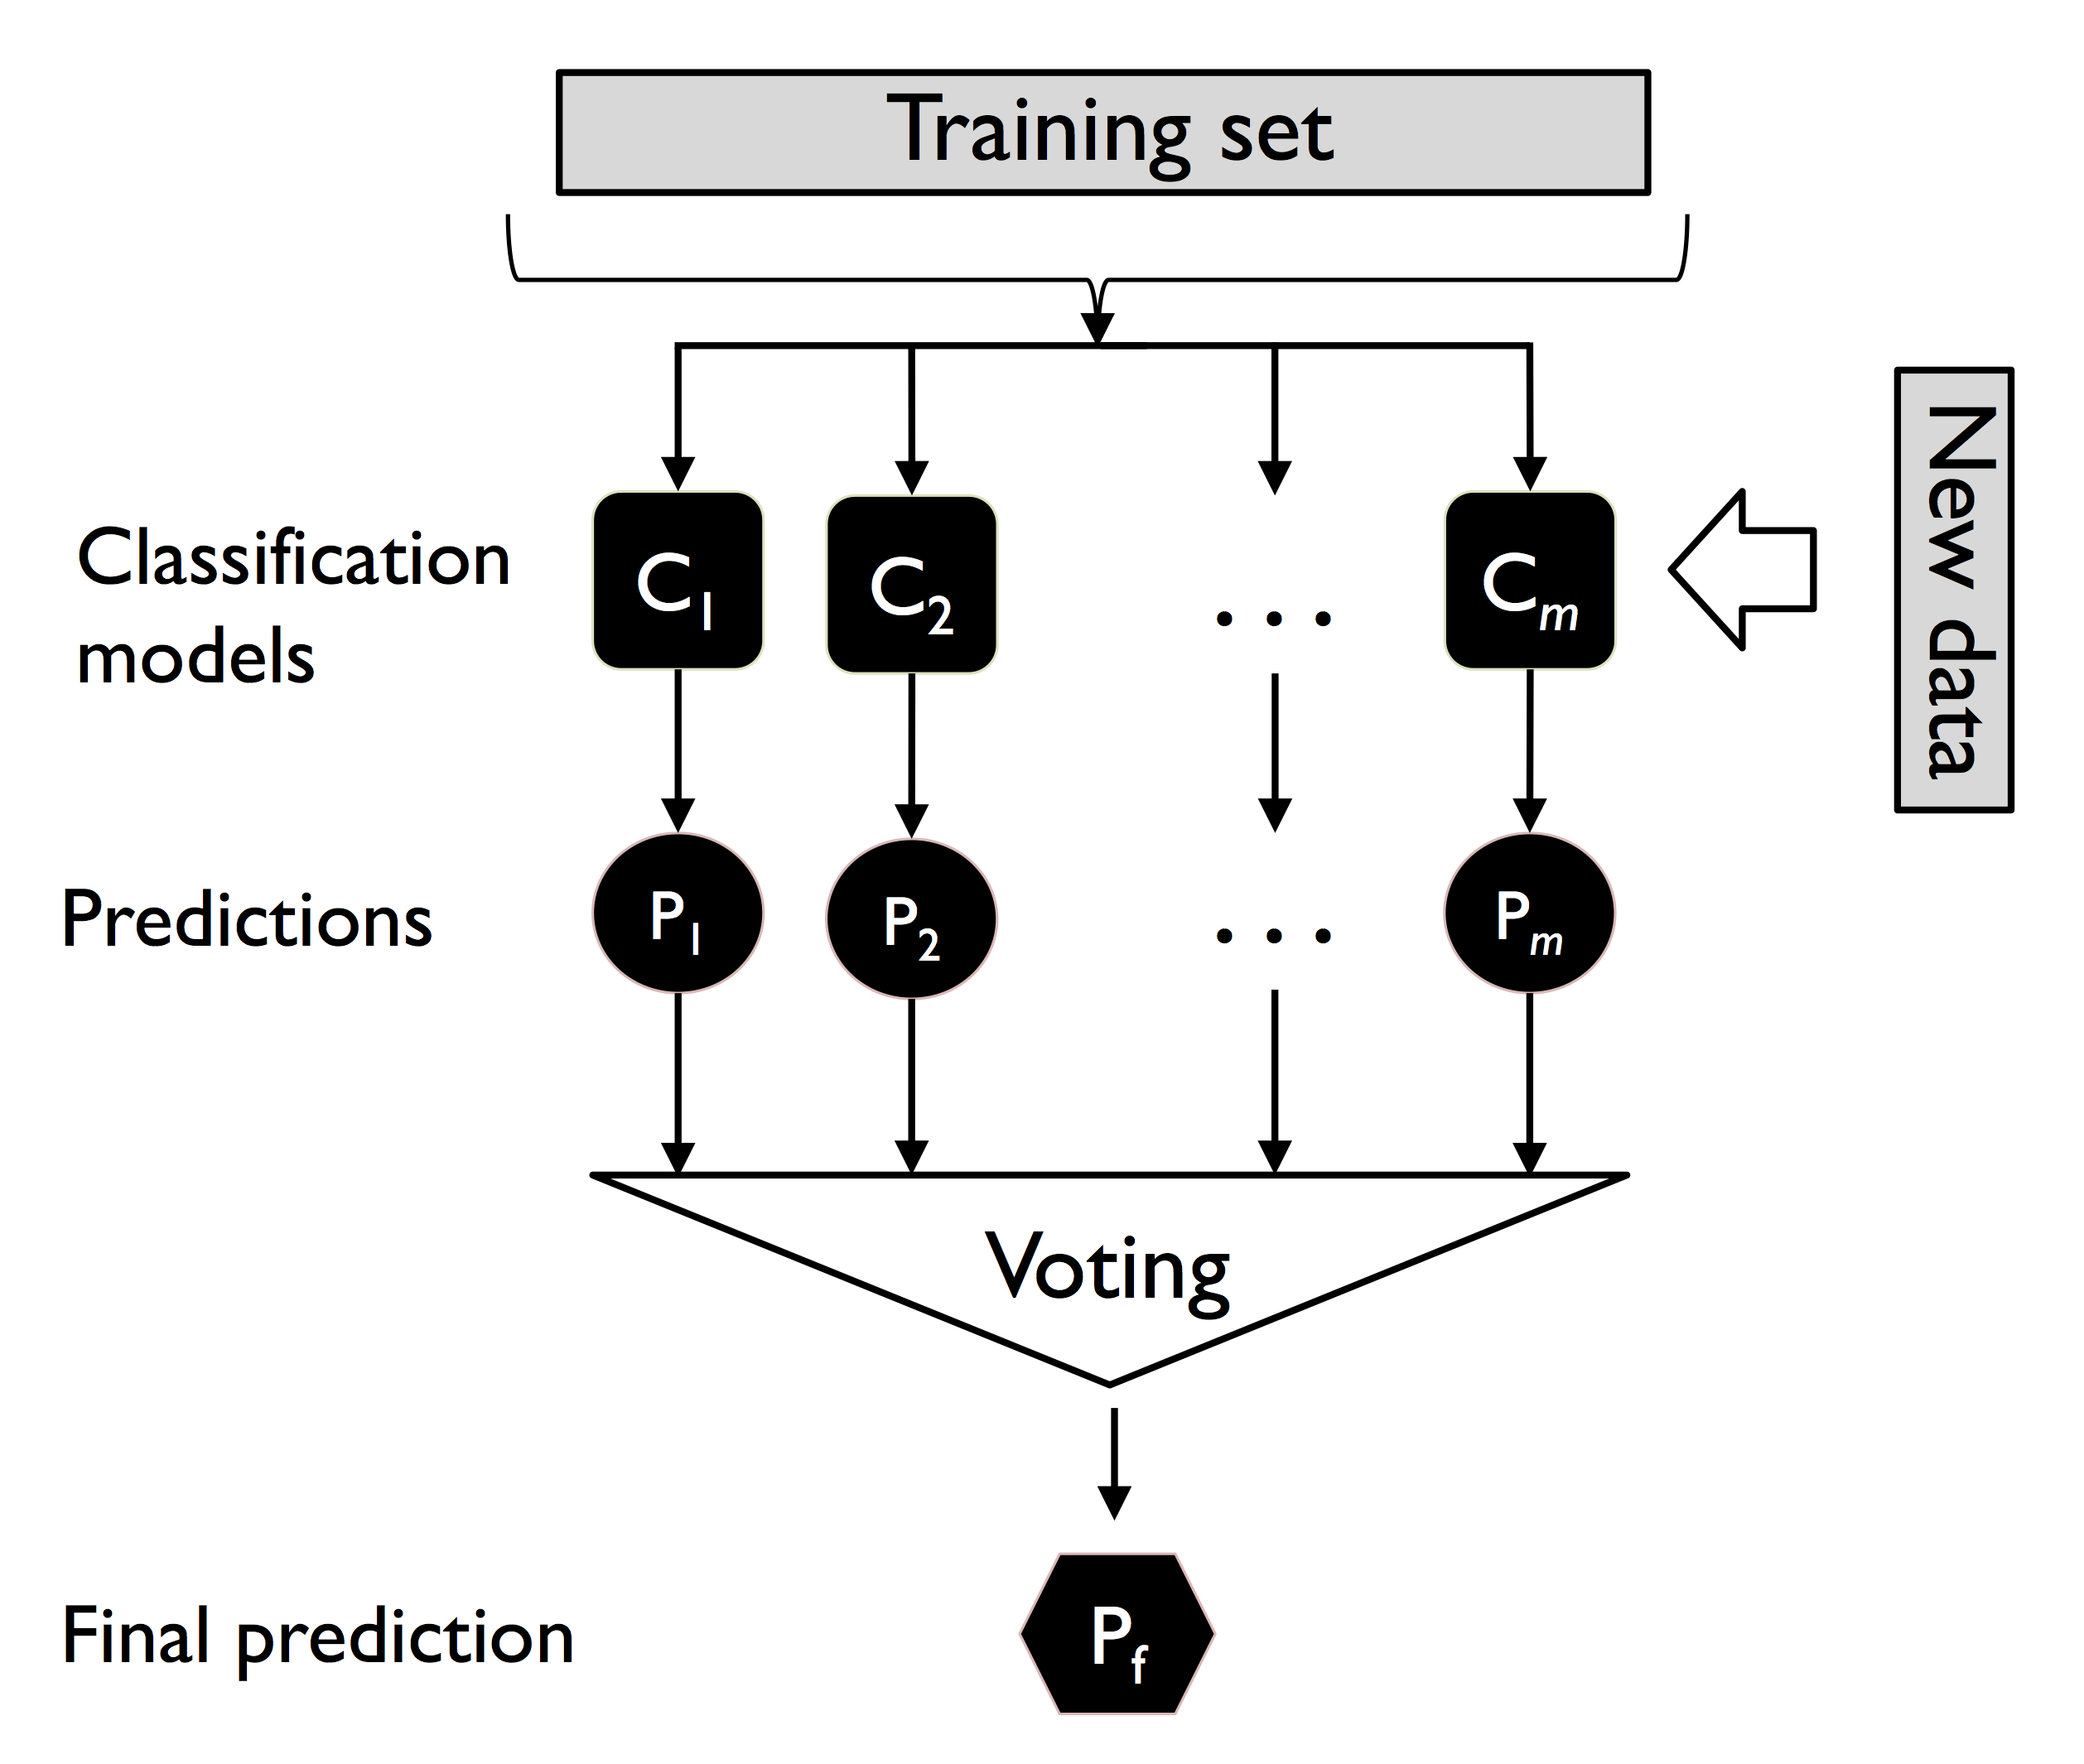

In [5]:
Image(filename='figures/07_02.png', width=500) 

In [6]:
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [7]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [8]:
import numpy as np


error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

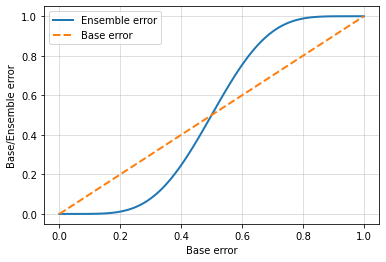

In [9]:
import matplotlib.pyplot as plt


plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('figures/07_03.png', dpi=300)
plt.show()

<br>
<br>

# Combining classifiers via majority vote

## Implementing a simple majority vote classifier 

In [10]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

In [11]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [12]:
np.argmax(p)

0

In [13]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

<br>
<br>

## Using the majority voting principle to make predictions

In [14]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [16]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


<br>
<br>

# Evaluating and tuning the ensemble classifier

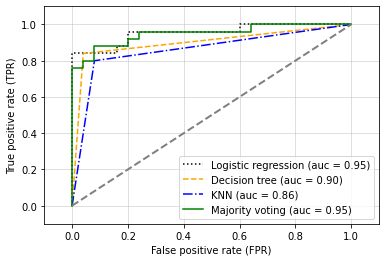

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('figures/07_04', dpi=300)
plt.show()

In [18]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

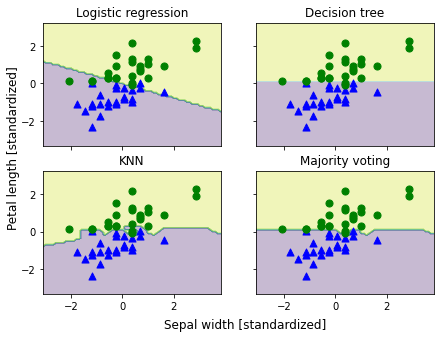

In [19]:
from itertools import product


all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('figures/07_05', dpi=300)
plt.show()

In [20]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [21]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [22]:
print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.2f}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.98


**Note**  
By default, the default setting for `refit` in `GridSearchCV` is `True` (i.e., `GridSeachCV(..., refit=True)`), which means that we can use the fitted `GridSearchCV` estimator to make predictions via the `predict` method, for example:

    grid = GridSearchCV(estimator=mv_clf, 
                        param_grid=params, 
                        cv=10, 
                        scoring='roc_auc')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

In addition, the "best" estimator can directly be accessed via the `best_estimator_` attribute.

In [23]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [24]:
mv_clf = grid.best_estimator_

In [25]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [26]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

<br>
<br>

# Bagging -- Building an ensemble of classifiers from bootstrap samples

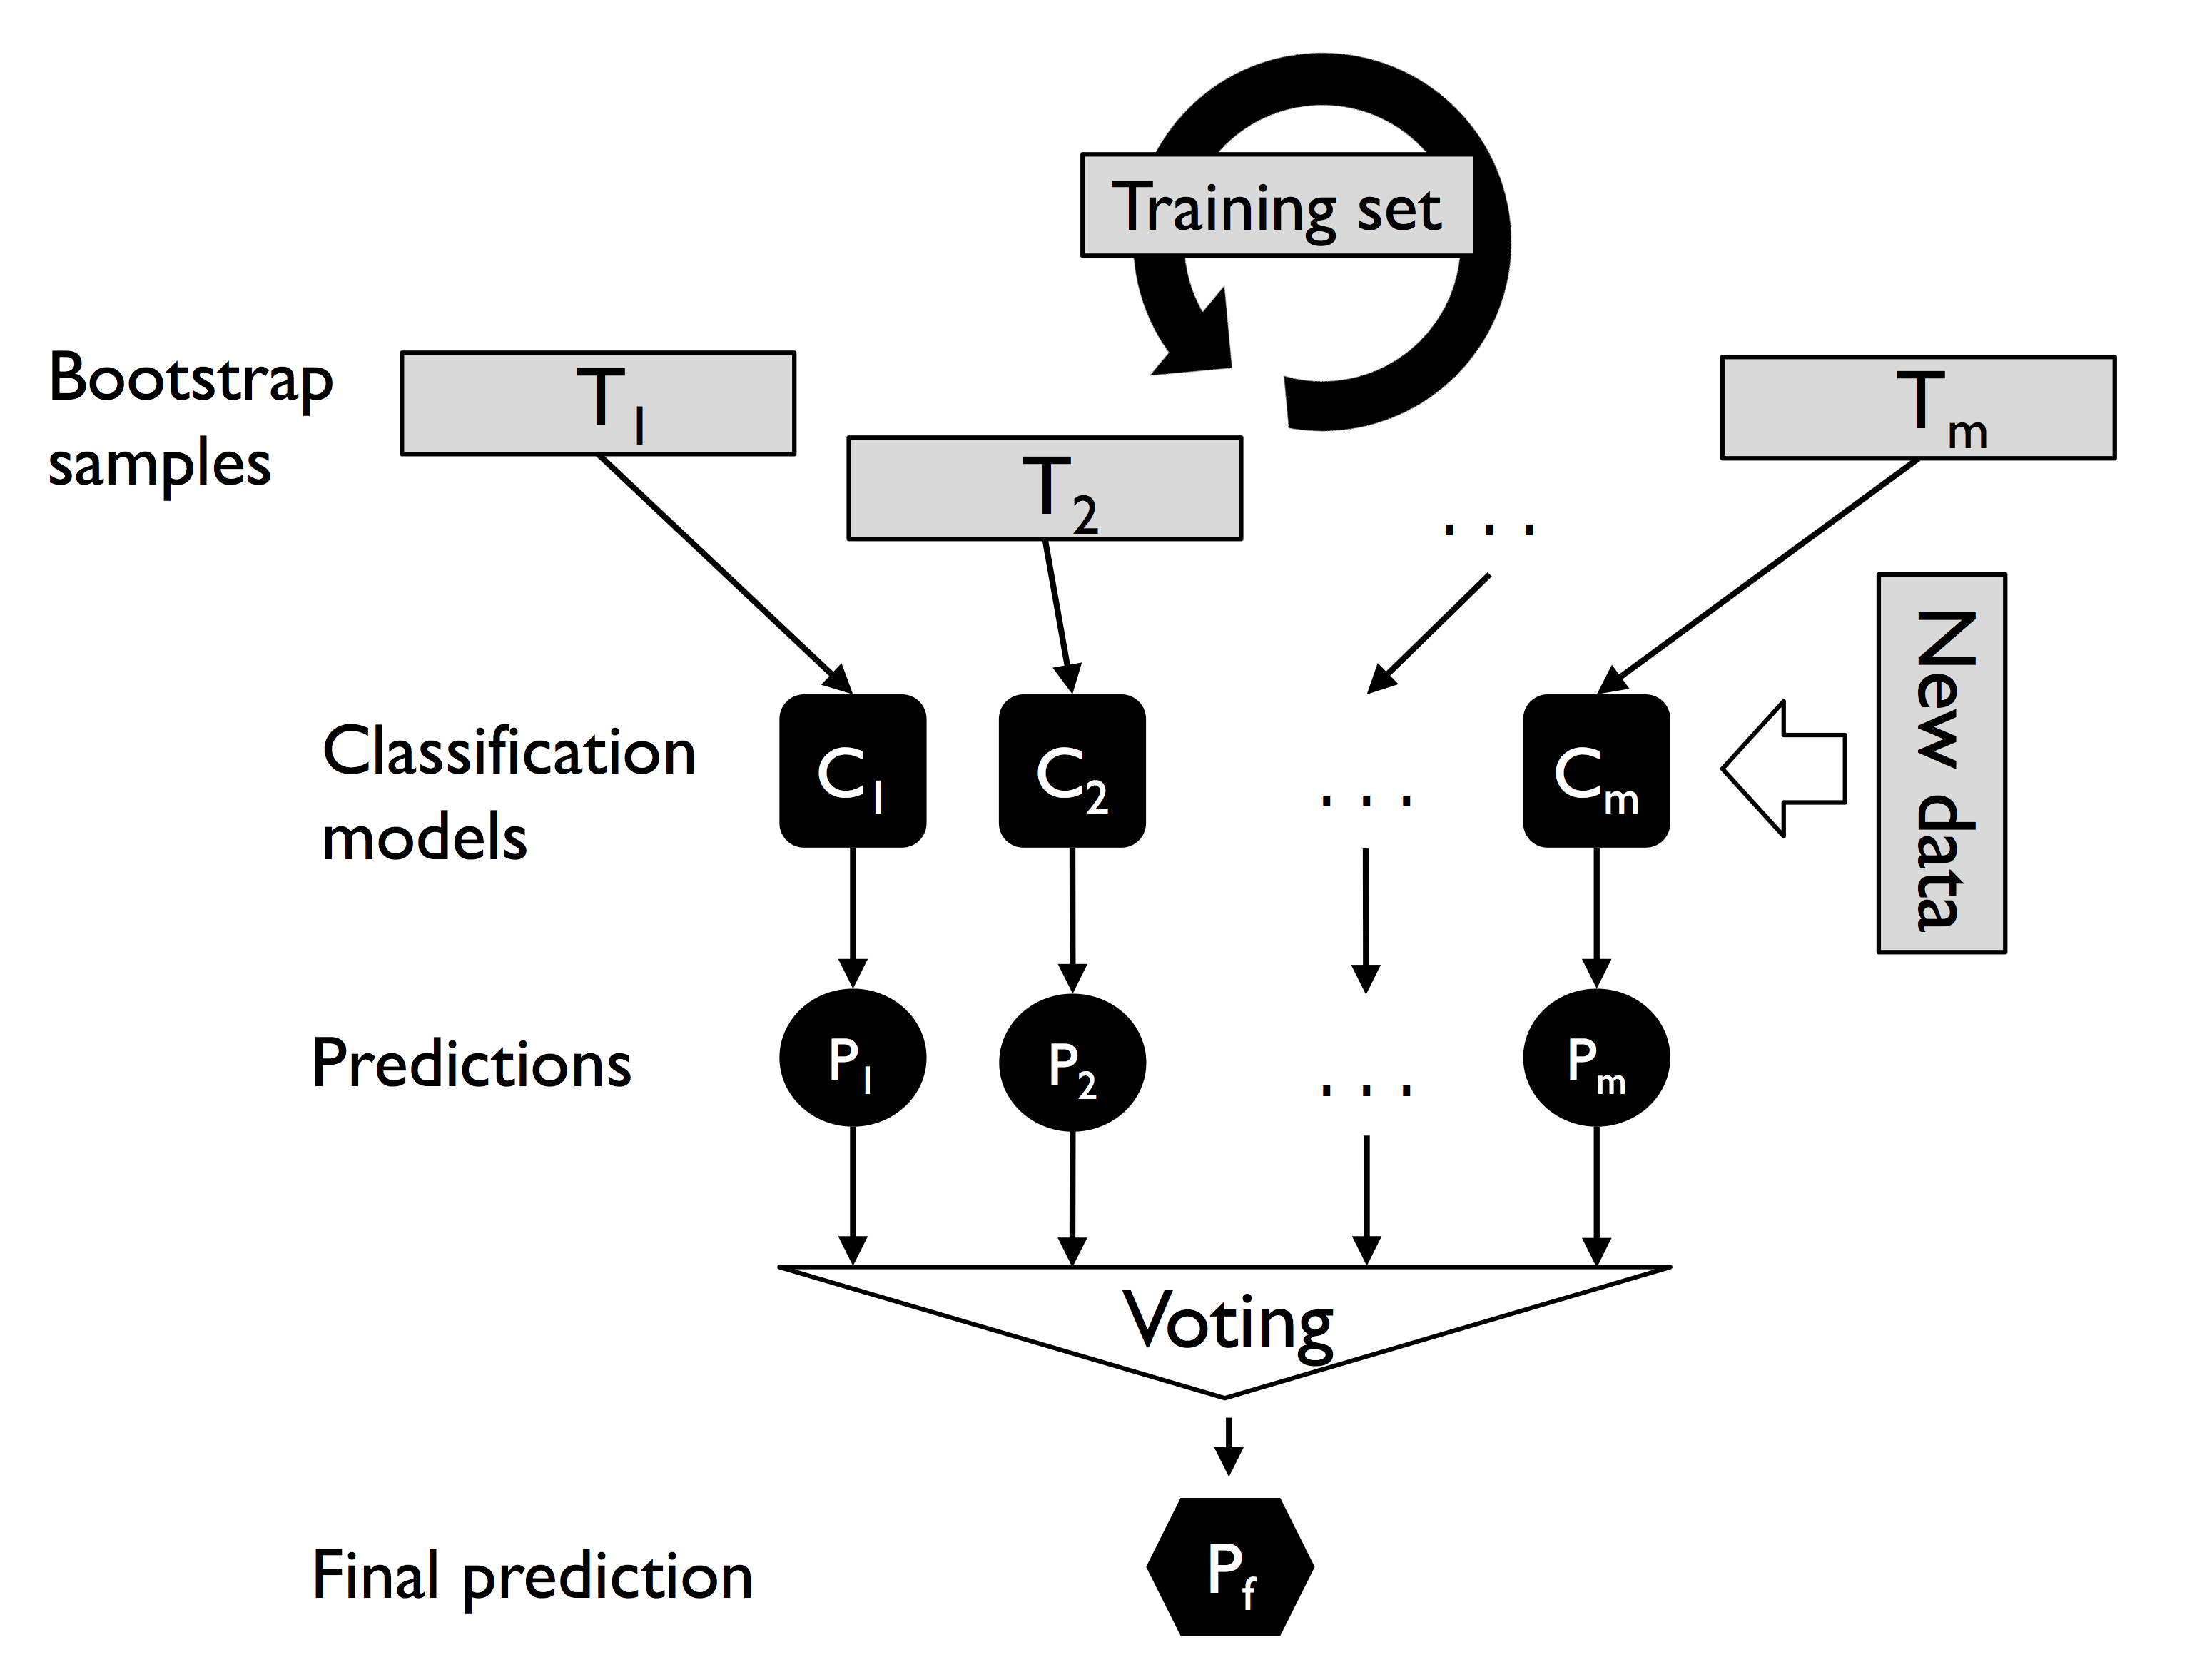

In [27]:
Image(filename='./figures/07_06.png', width=500) 

## Bagging in a nutshell

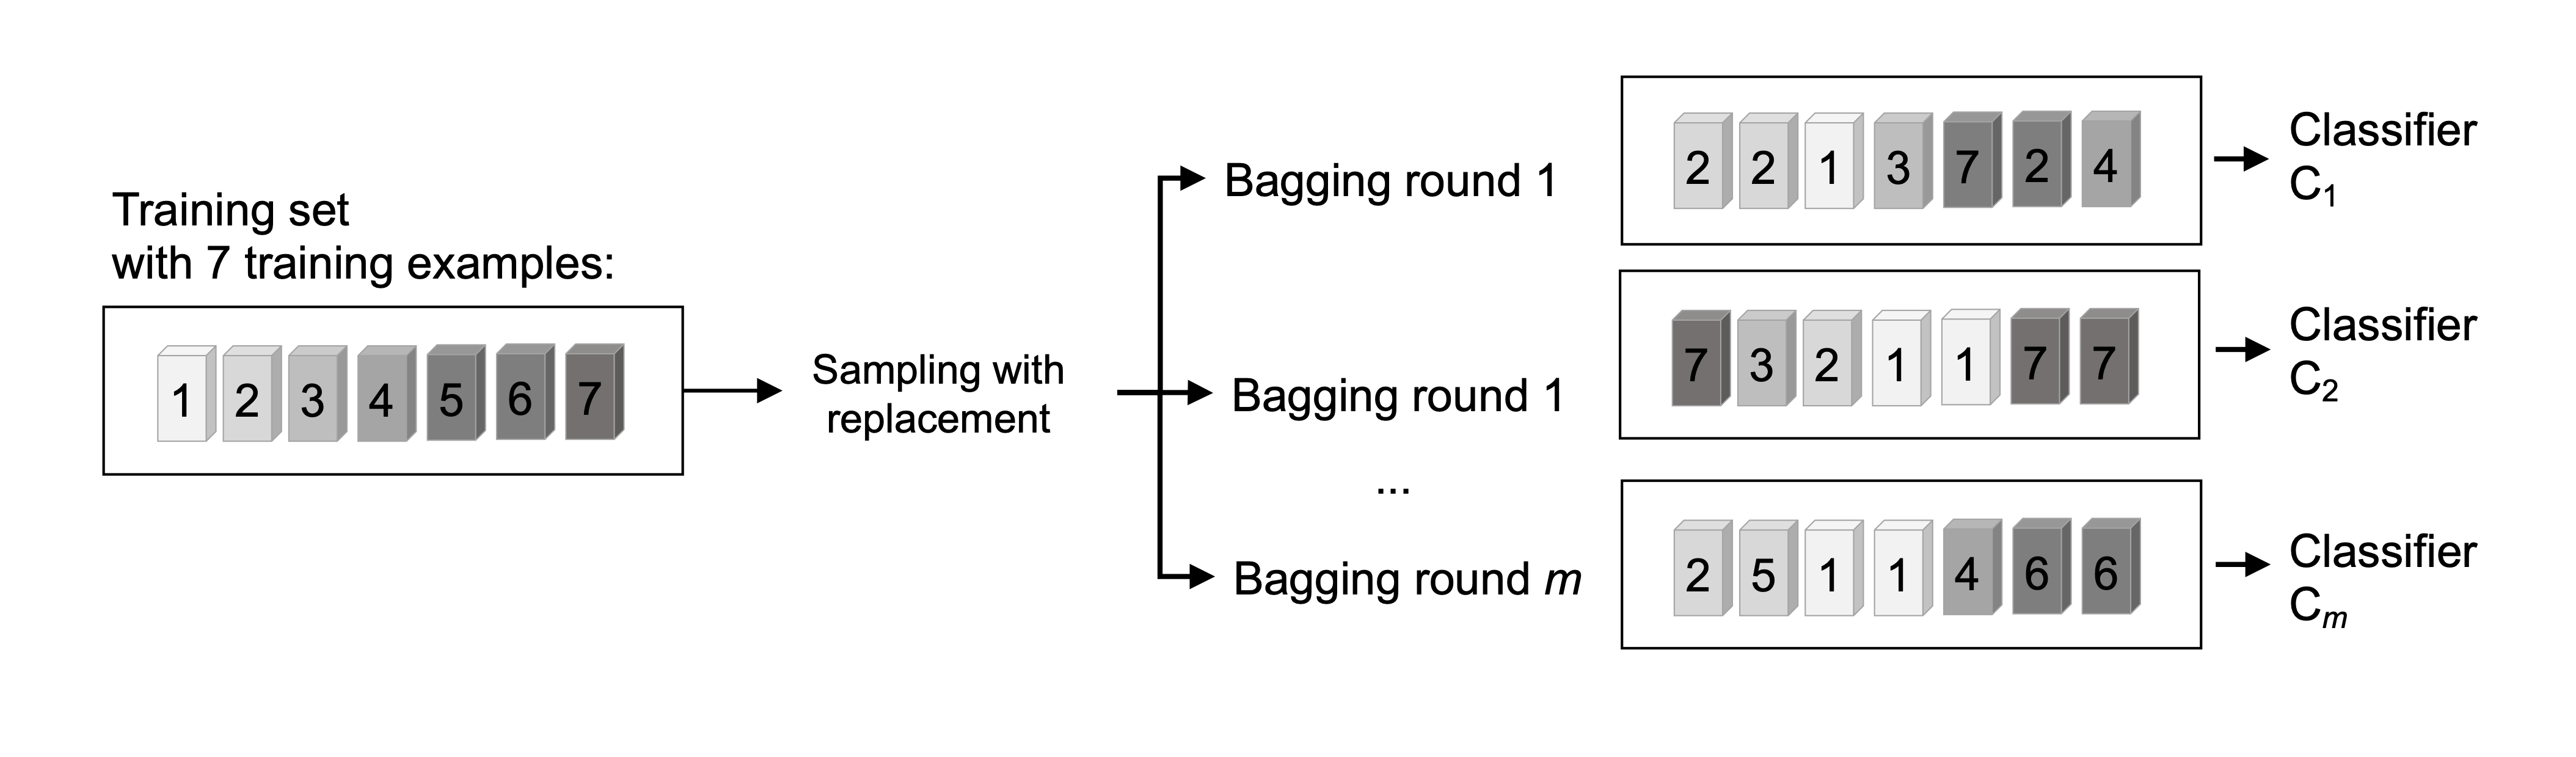

In [28]:
Image(filename='./figures/07_07.png', width=800) 

## Applying bagging to classify examples in the Wine dataset

In [29]:
import pandas as pd


df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [32]:
from sklearn.metrics import accuracy_score


tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print(f'Bagging train/test accuracies '
      f'{bag_train:.3f}/{bag_test:.3f}')

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


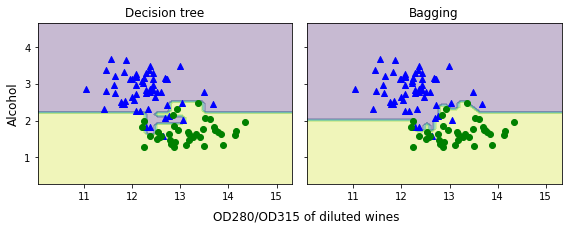

In [33]:
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('figures/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

# Leveraging weak learners via adaptive boosting

## How boosting works

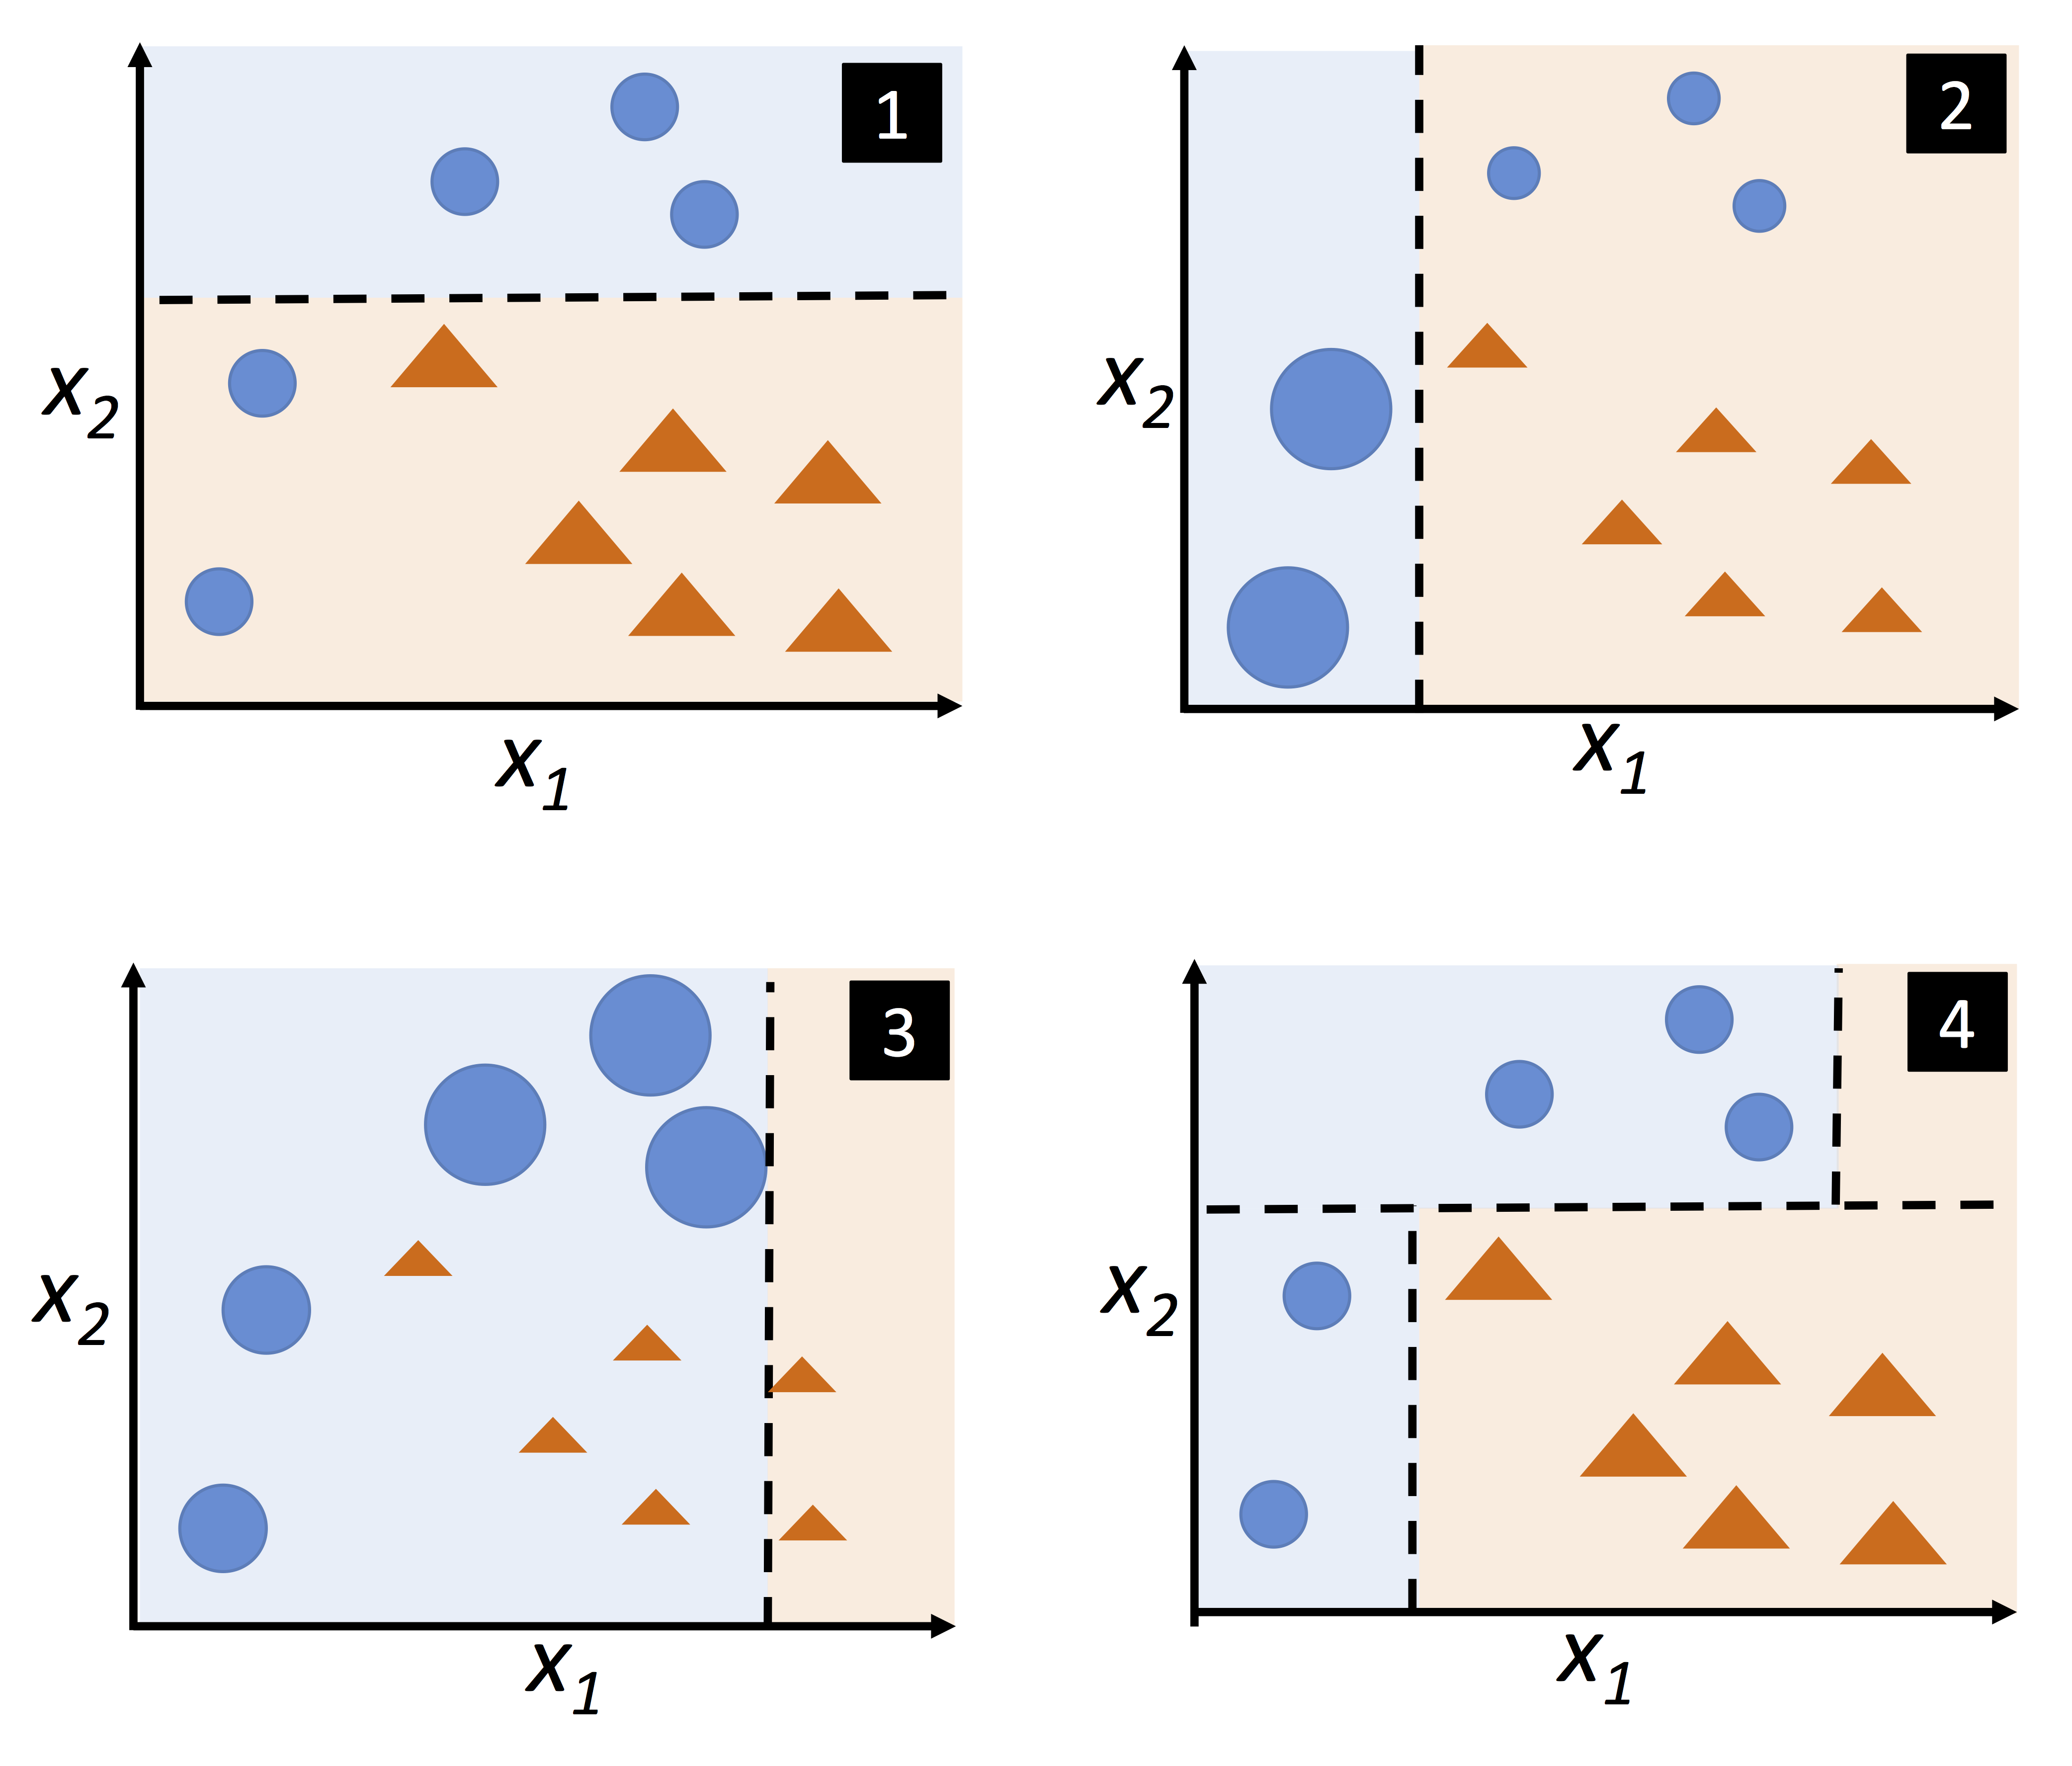

In [34]:
Image(filename='figures/07_09.png', width=400) 

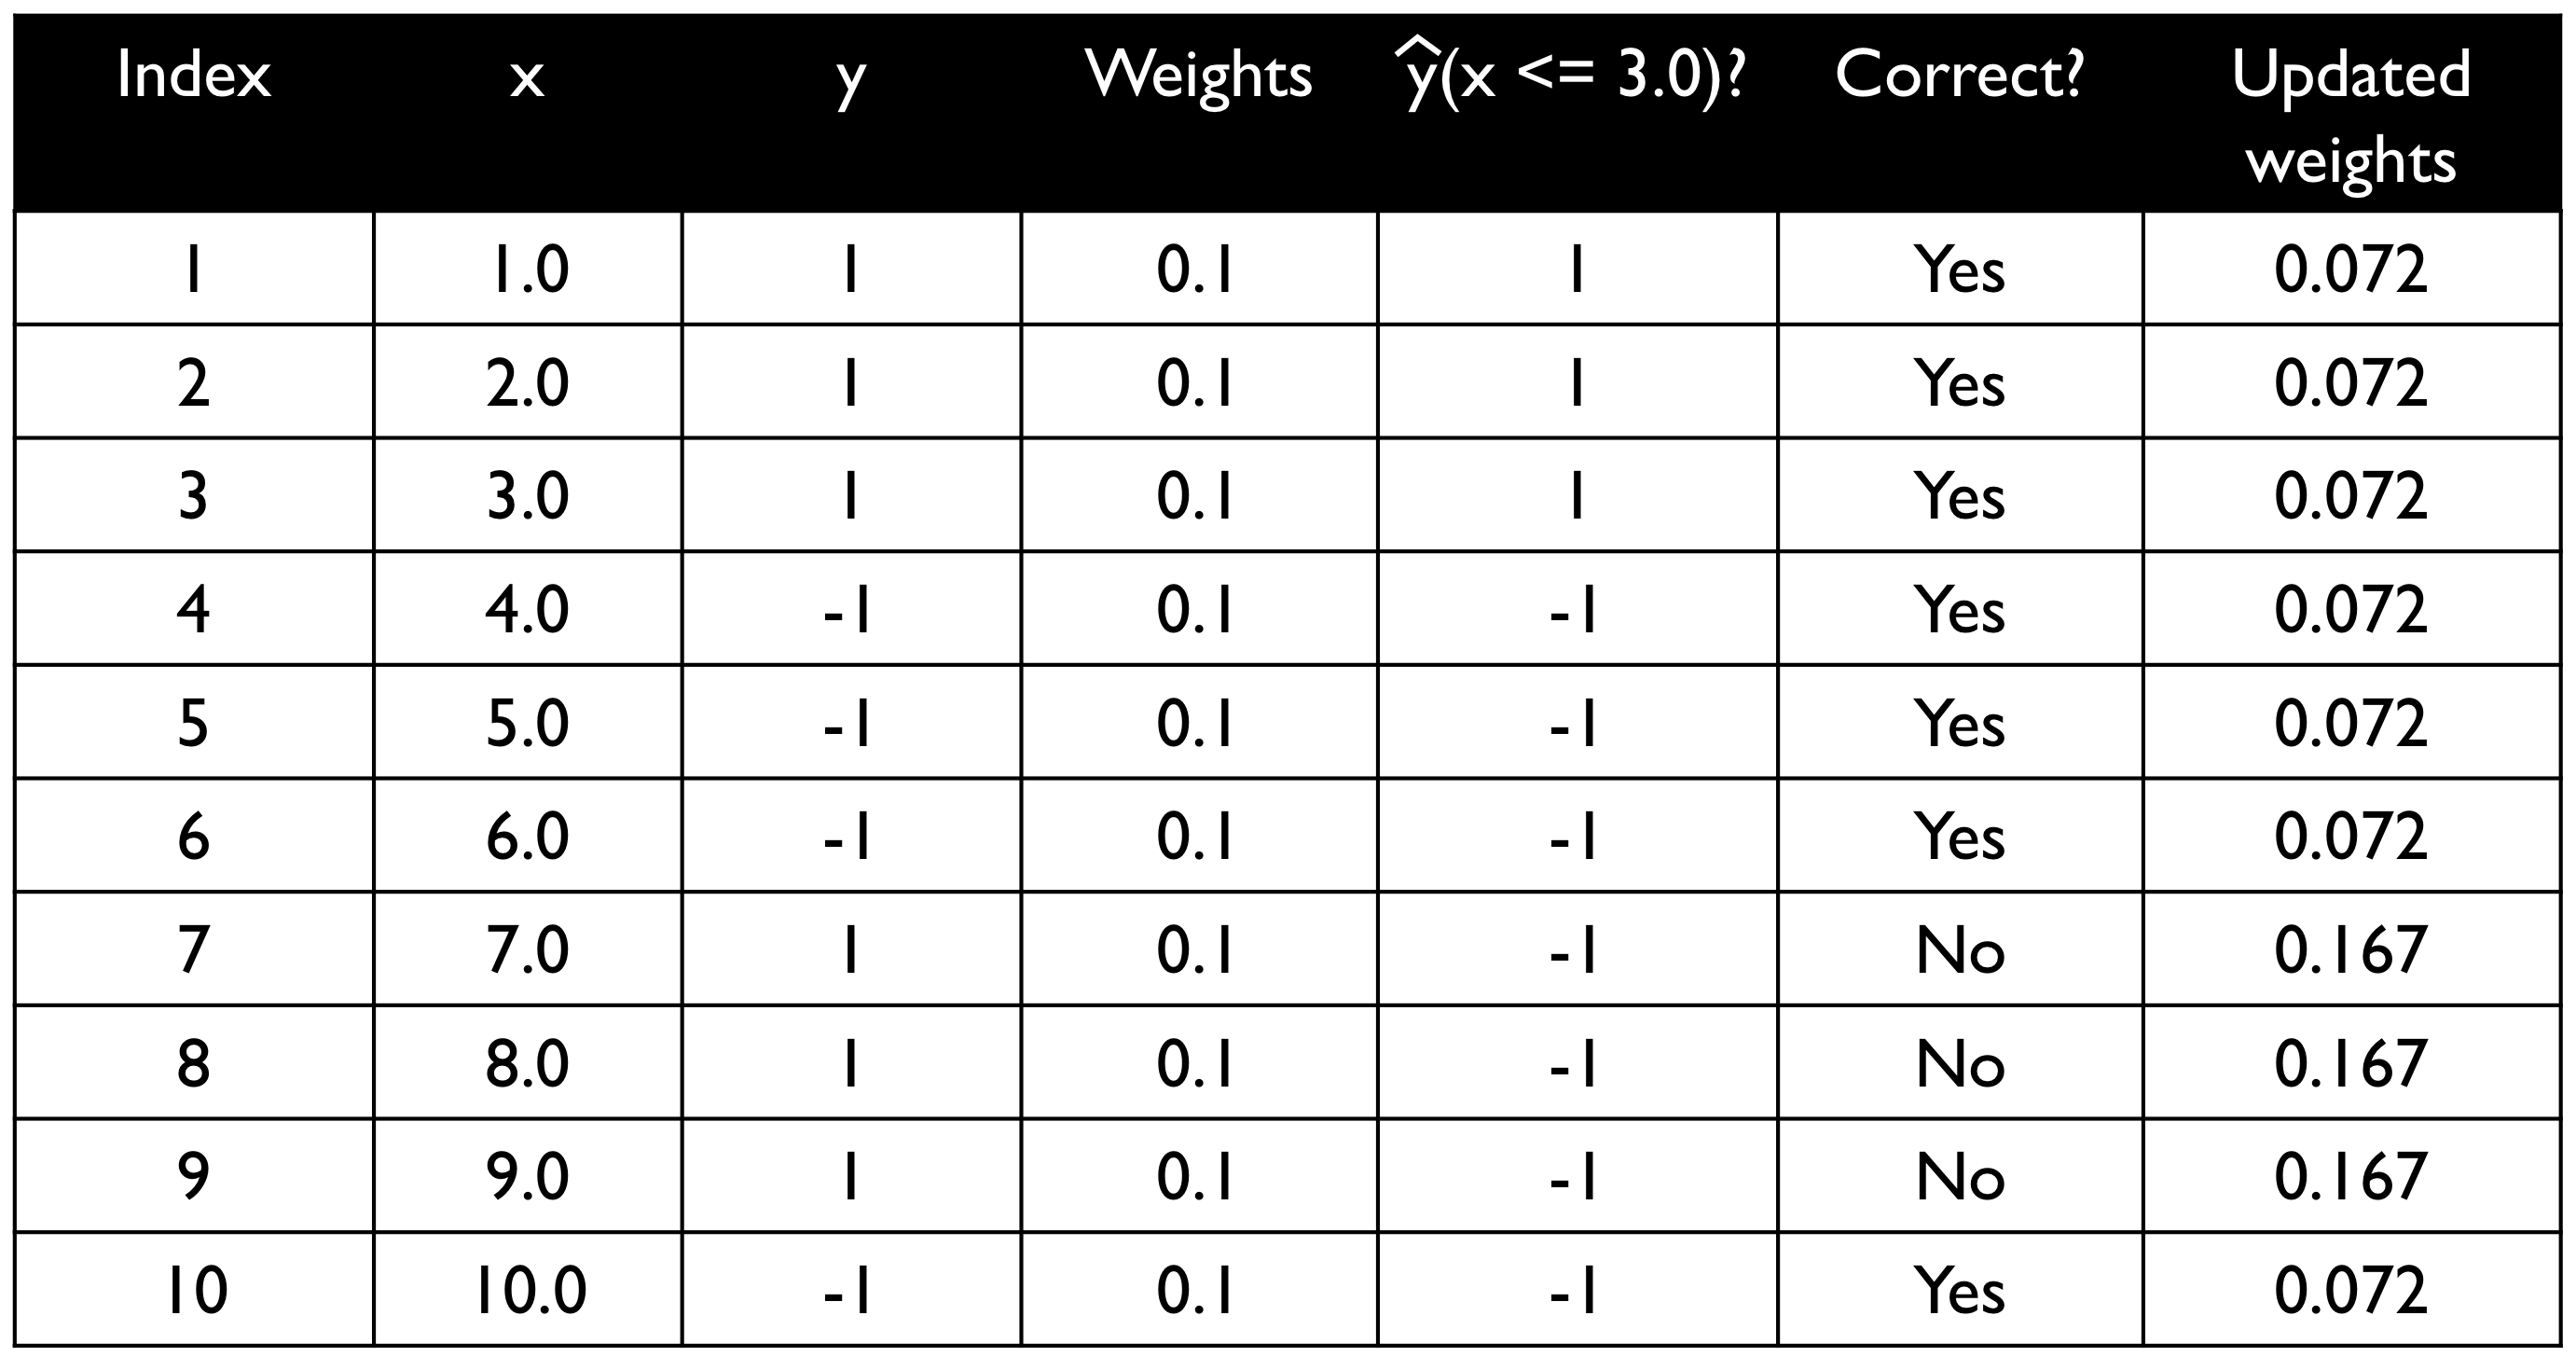

In [35]:
Image(filename='figures/07_10.png', width=500) 

In [36]:
y = np.array([1, 1, 1, -1, -1, -1,  1,  1,  1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
print(weights)

epsilon = np.mean(~correct)
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [37]:
alpha_j = 0.5 * np.log((1-epsilon) / epsilon)
print(alpha_j)

0.42364893019360184


In [38]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
print(update_if_correct)

0.06546536707079771


In [39]:
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_1)

0.1527525231651947


In [40]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * -1 * 1)
print(update_if_wrong_2)

0.1527525231651947


In [41]:
weights = np.where(correct == 1, update_if_correct, update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [42]:
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


## Applying AdaBoost using scikit-learn

In [43]:
from sklearn.ensemble import AdaBoostClassifier


tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [44]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


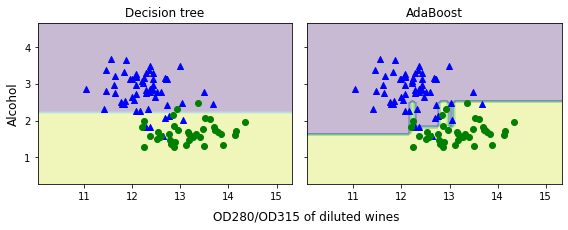

In [45]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('figures/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

# Gradient boosting -- training an ensemble based on loss gradients

## Comparing AdaBoost with gradient boosting

## Outlining the general gradient boosting algorithm

## Explaining the gradient boosting algorithm for classification

## Illustrating gradient boosting for classification

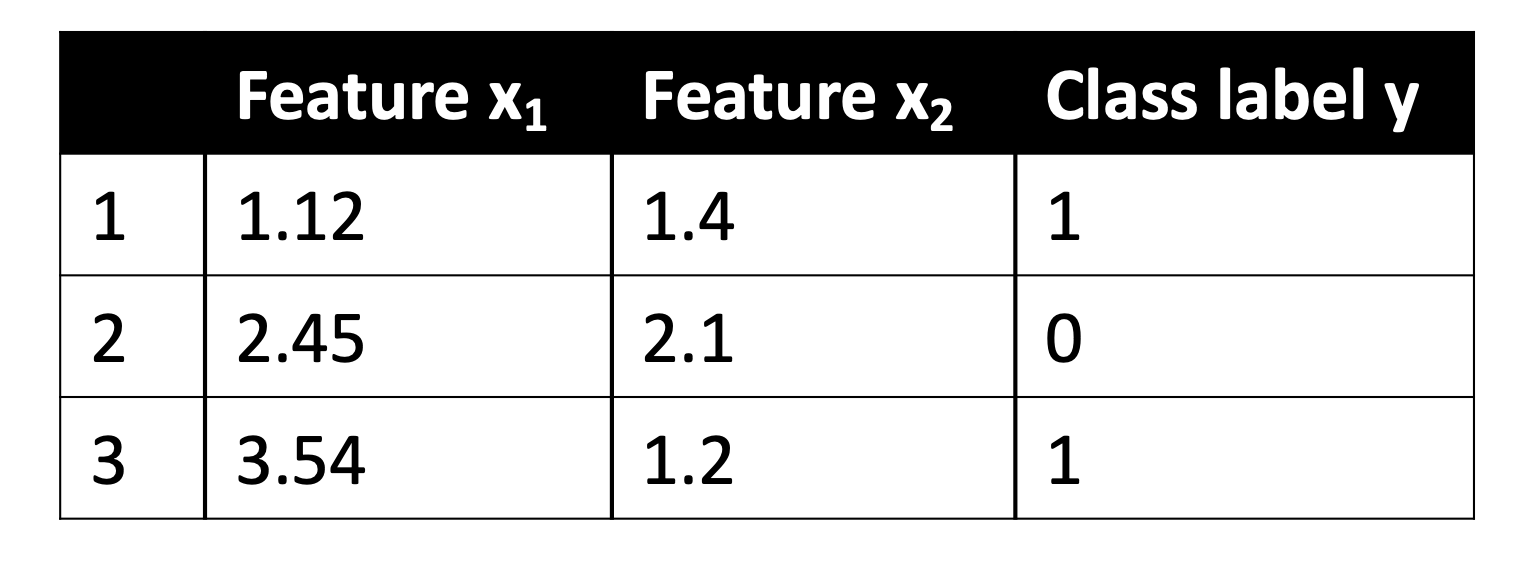

In [46]:
Image(filename='./figures/07_12.png', width=300) 

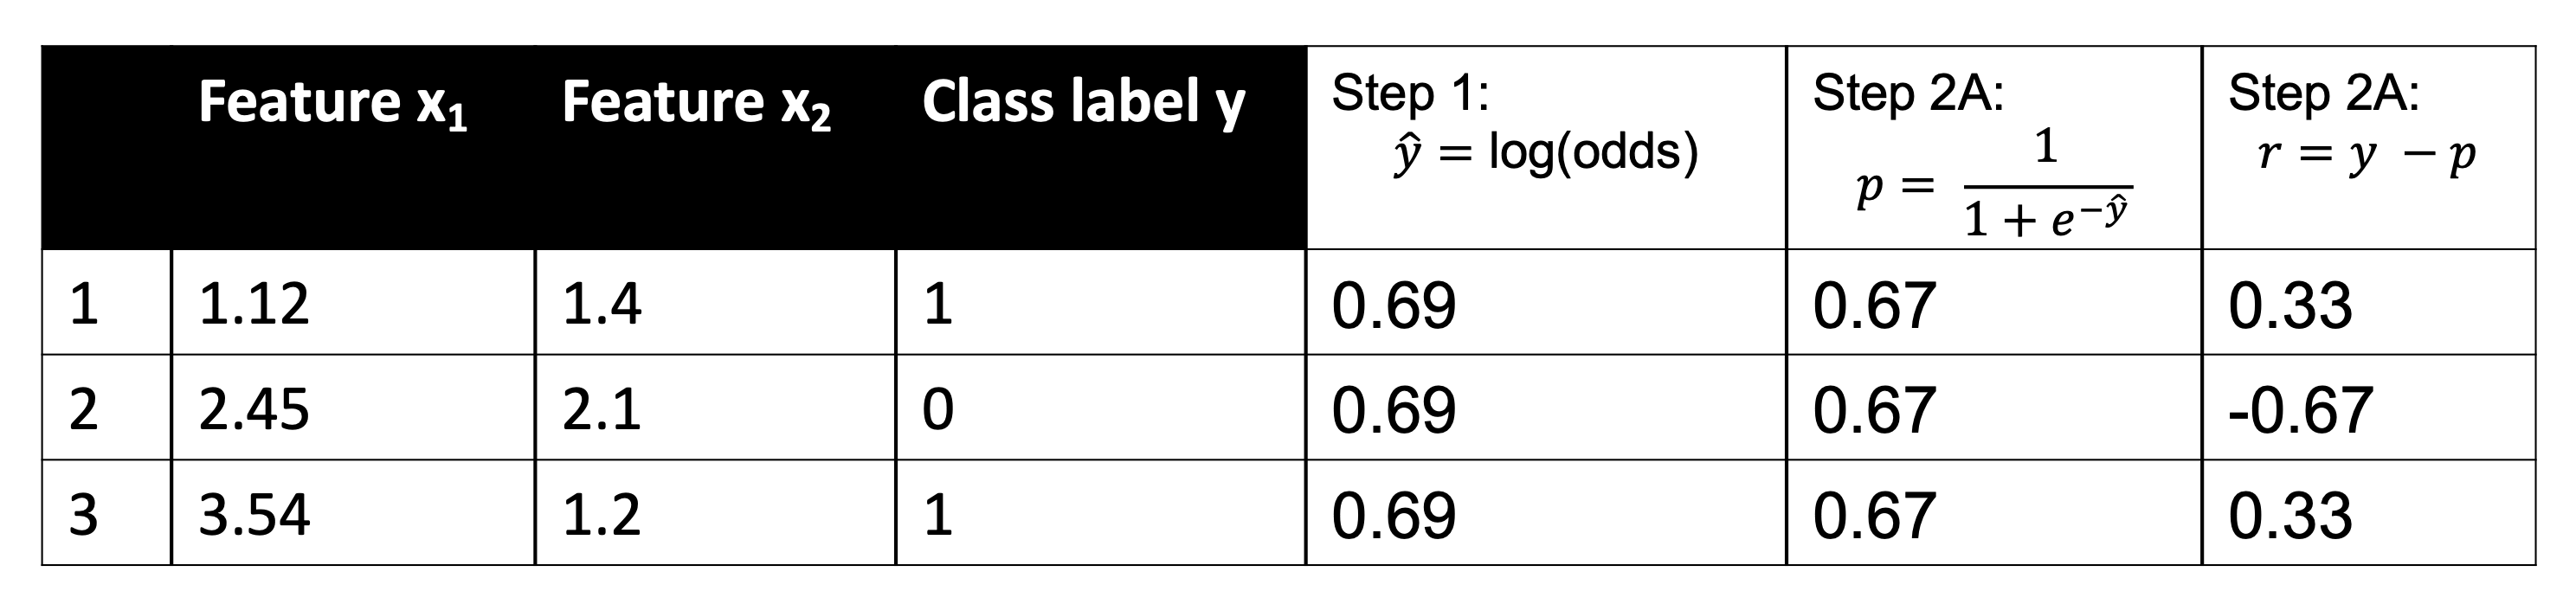

In [47]:
Image(filename='./figures/07_13.png', width=750) 

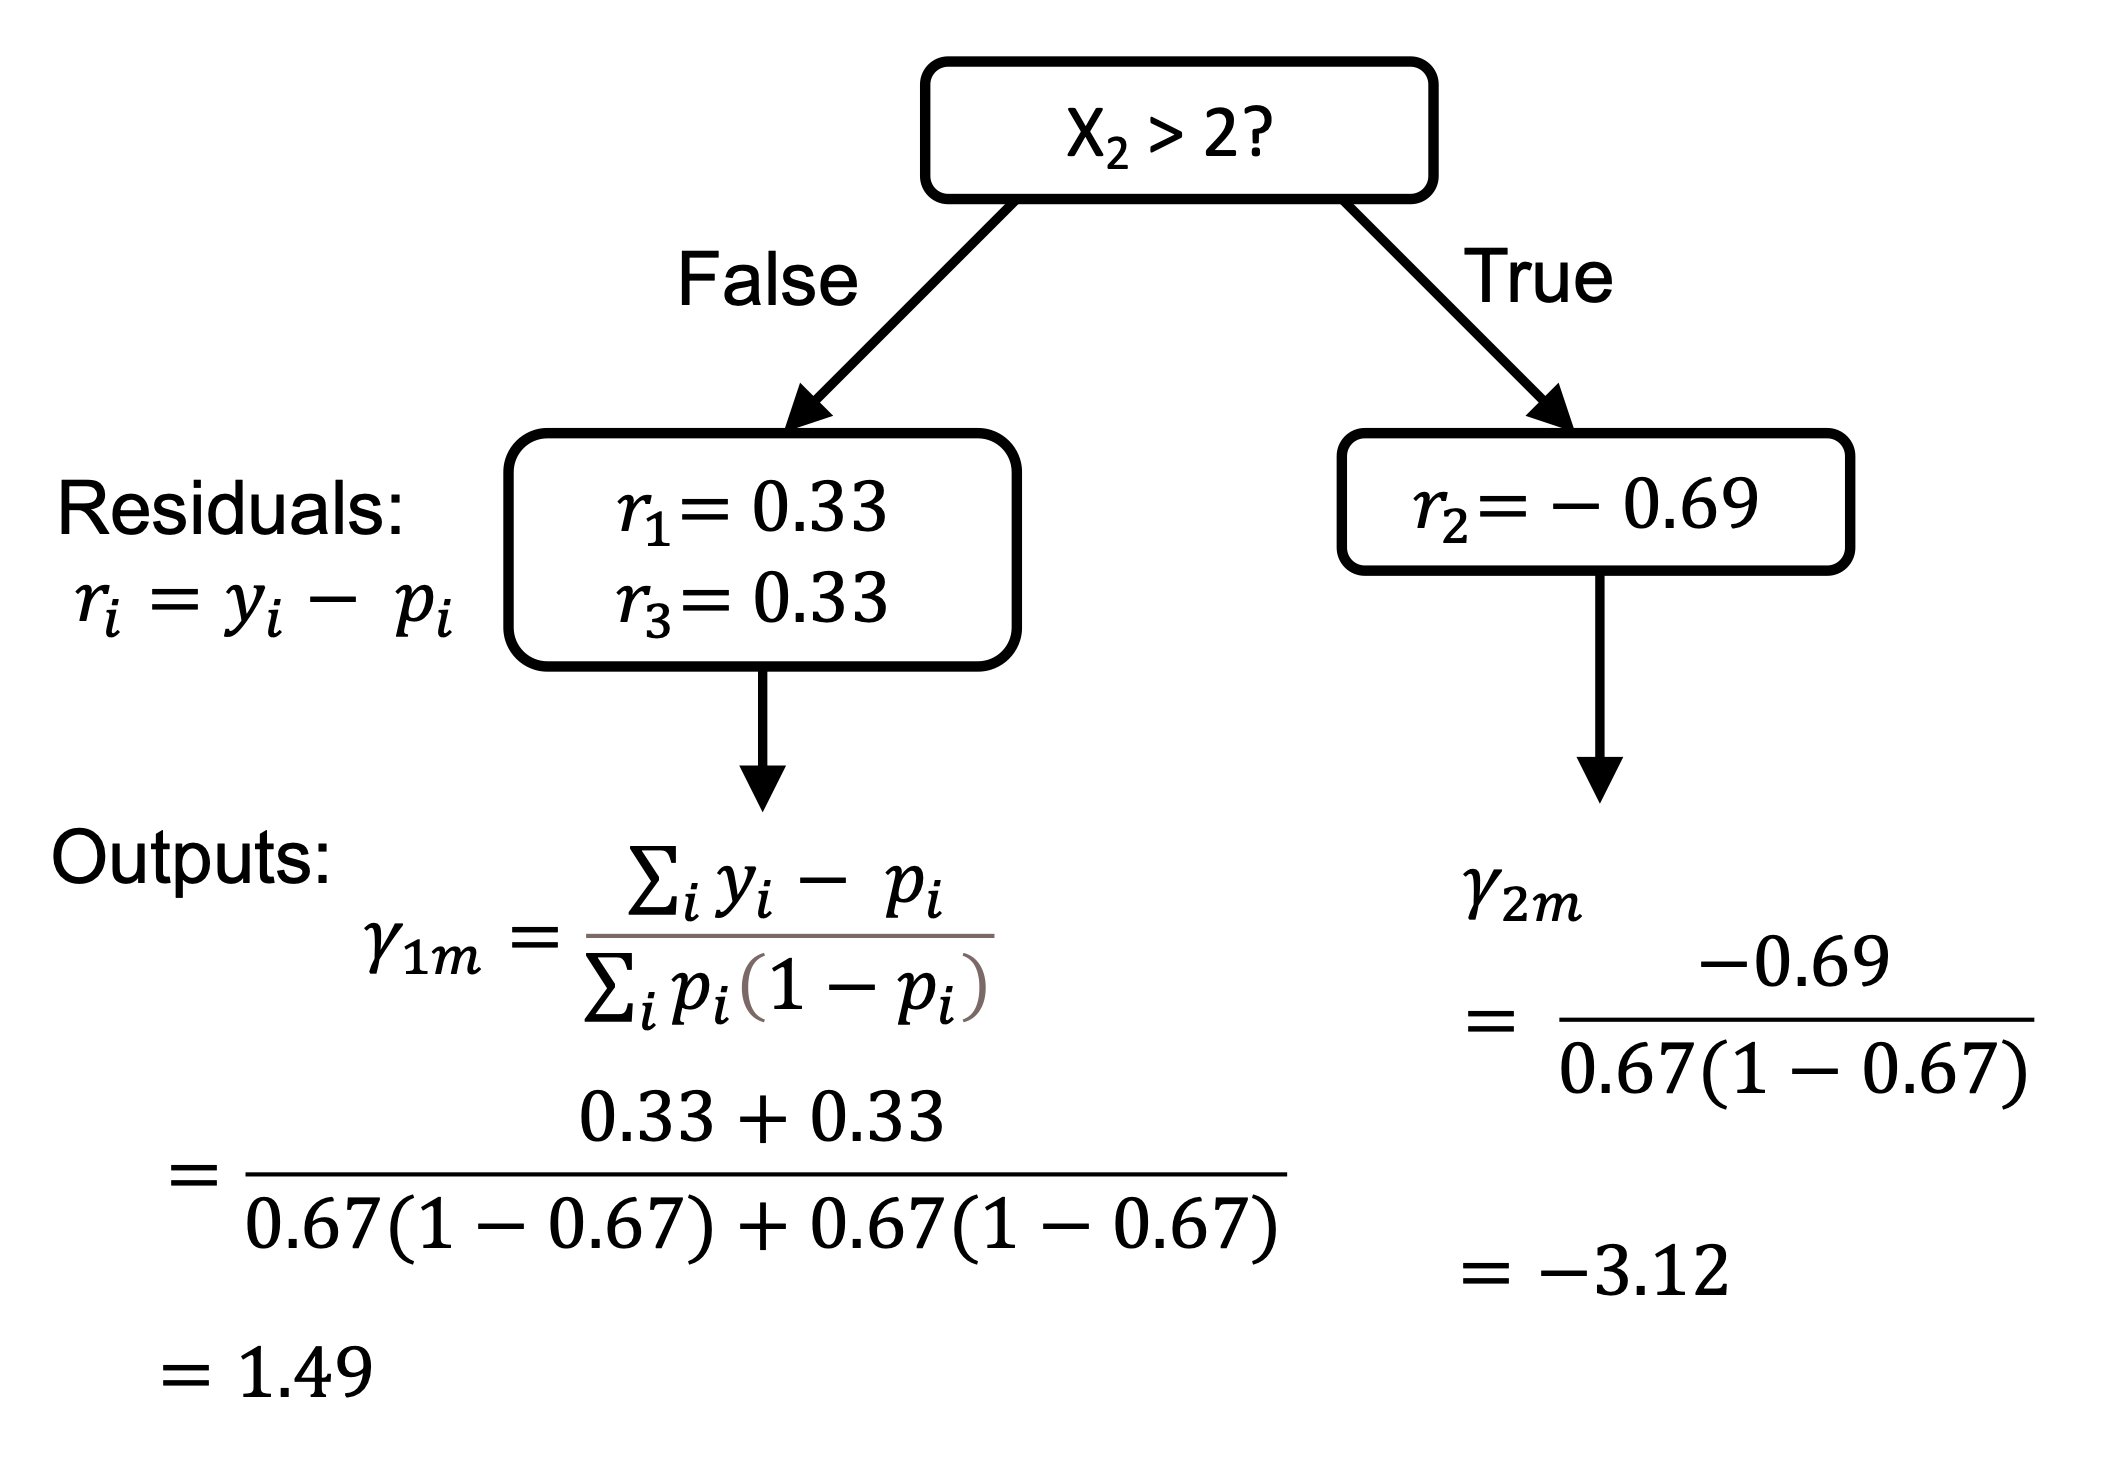

In [48]:
Image(filename='./figures/07_14.png', width=500) 

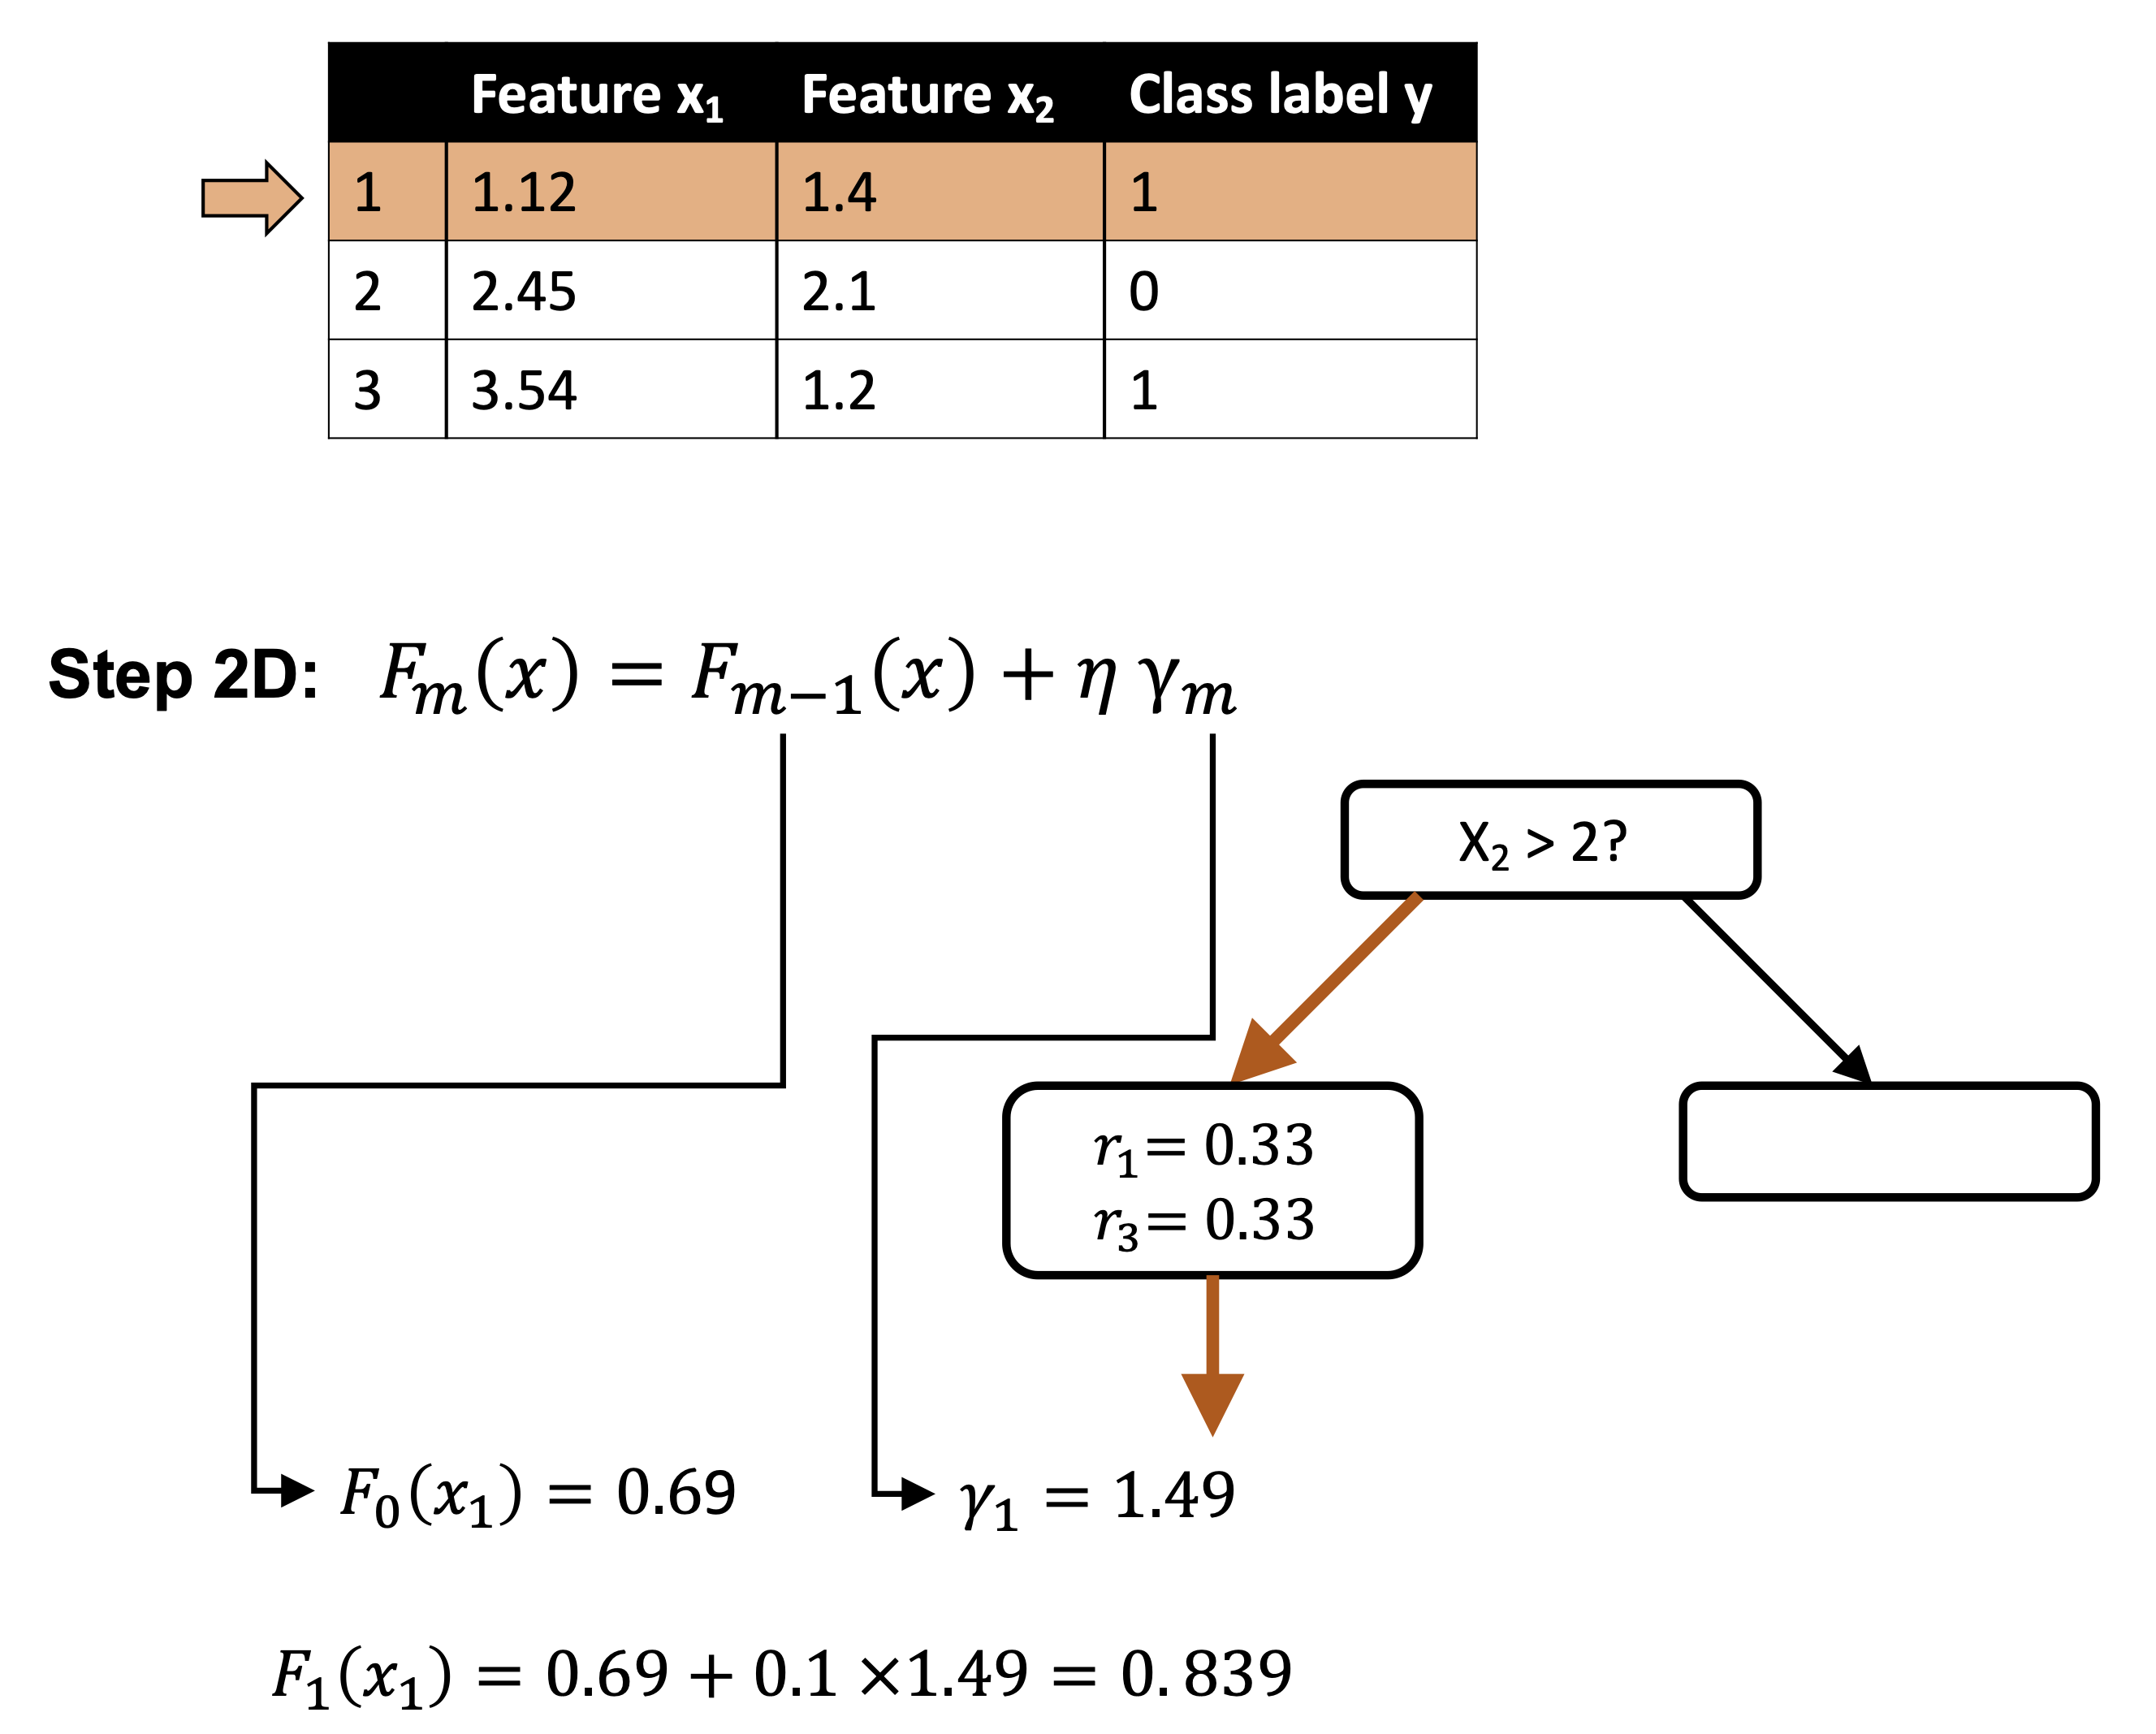

In [49]:
Image(filename='./figures/07_15.png', width=500) 

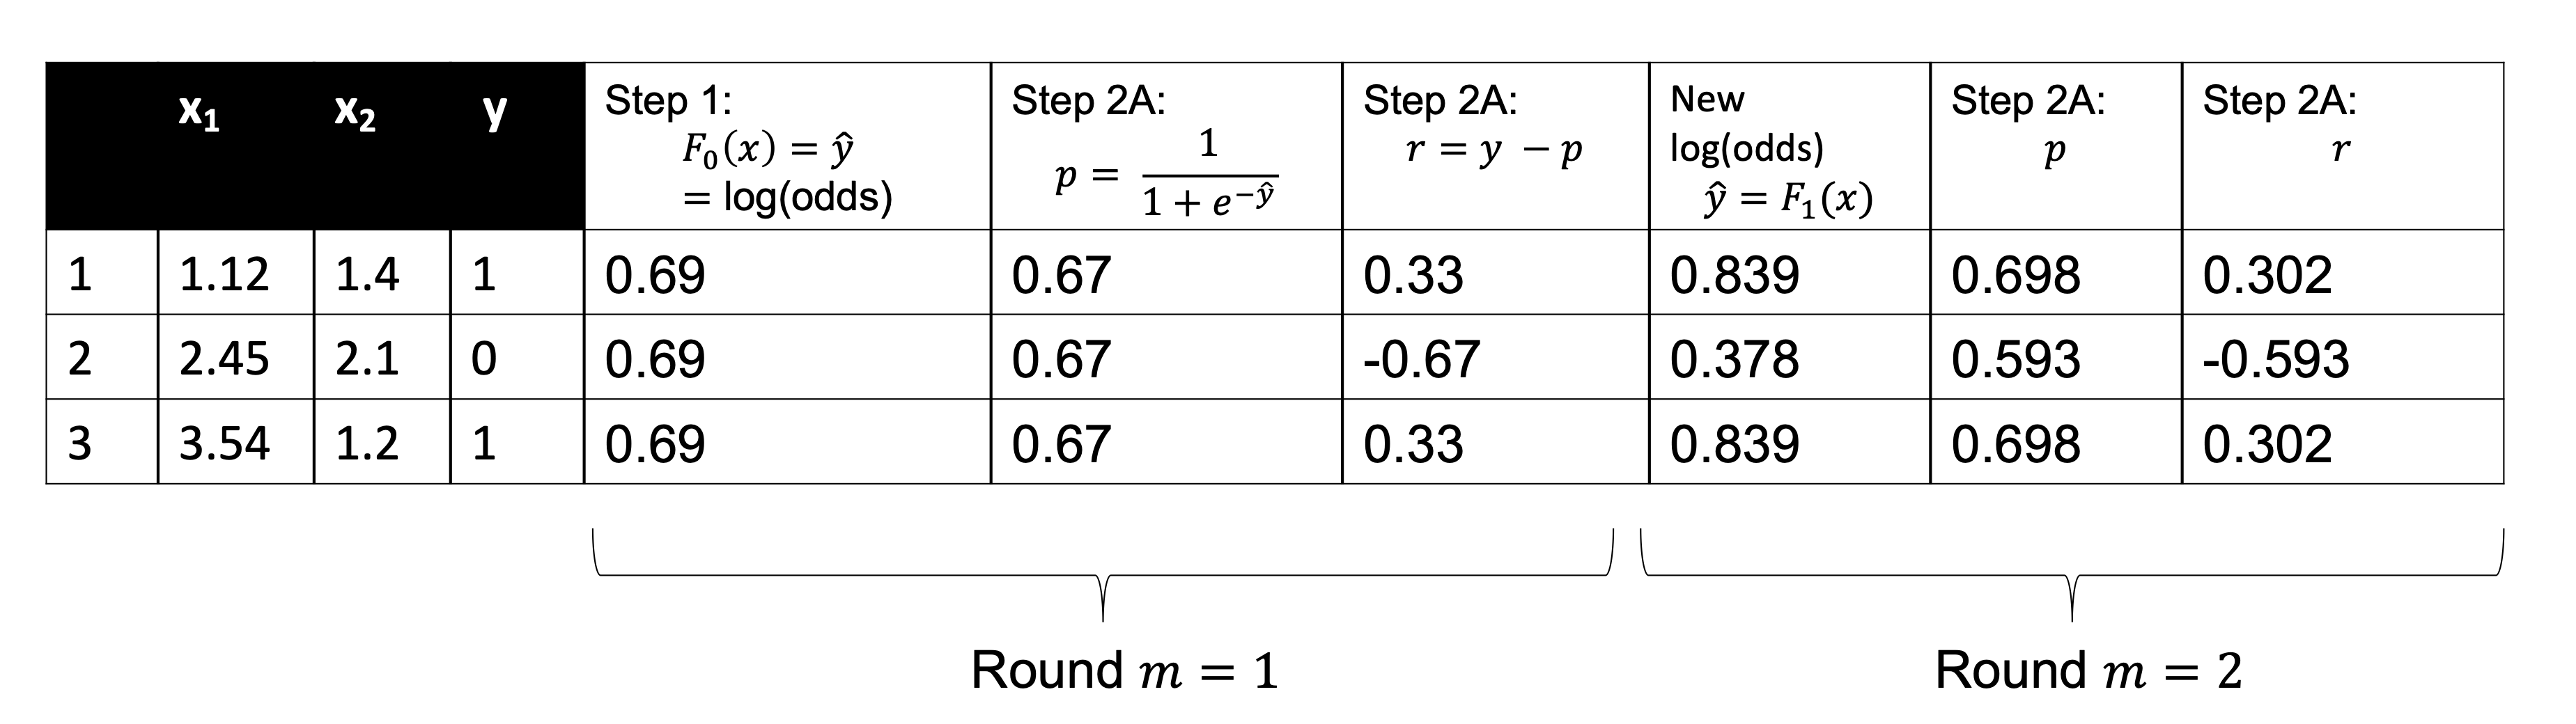

In [50]:
Image(filename='./figures/07_16.png', width=800) 

## Using XGboost 

In [51]:
import xgboost as xgb

In [52]:
xgb.__version__

'1.5.1'

In [53]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)


gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred) 
gbm_test = accuracy_score(y_test, y_test_pred) 
print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

[15:17:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGboost train/test accuracies 0.968/0.917


<br>
<br>

# Summary

...

---

Readers may ignore the next cell.

In [54]:
! python ../.convert_notebook_to_script.py --input ch07.ipynb --output ch07.py

[NbConvertApp] Converting notebook ch07.ipynb to script
[NbConvertApp] Writing 24357 bytes to ch07.py
